# MNIST

In this tutorial, we will show you how to train a small convolutional neural network (a CNN) model. We will be training the model on the MNIST dataset, which consists of labeled handwritten digits. Each sample is a 28x28 picture of a handwritten single digit and the label is a digit from 0 to 9.

We will be constructing the [LeNet model](http://yann.lecun.com/exdb/lenet/) with the sigmoid activations replaced with [ReLUs](http://www.cs.toronto.edu/~fritz/absps/reluICML.pdf). A flag below will allow us to toggle between the LeNet model and a simple MLP (multilayer perceptron) architectures.

We will be using ModelHelper - the class that helps us deal with parameter initialization naturally.

First, let's import the necessities.

In [1]:
from matplotlib import pyplot
import numpy as np
import os
import shutil
import caffe2.python.predictor.predictor_exporter as pe


from caffe2.python import (
    brew,
    core,
    model_helper,
    net_drawer,
    optimizer,
    visualize,
    workspace,
)

# If you would like to see some really detailed initializations,
# you can change --caffe2_log_level=0 to --caffe2_log_level=-1
core.GlobalInit(['caffe2', '--caffe2_log_level=0'])
print("Necessities imported!")

# If True, a more complicated convolutional model is used
# If False, a multilayer perceptron model is used
USE_LENET_MODEL = True

Necessities imported!


We will track statistics during the training time and store these on disk in a local folder. We need to set up a data folder for the data and a root folder for the stats. You should already have these folders, and in the data folder the MNIST dataset should be setup as a lmdb database for both the training set and the test set for this tutorial. 

In [2]:
# This section preps your image and test set in a lmdb database
def DownloadResource(url, path):
    '''Downloads resources from s3 by url and unzips them to the provided path'''
    import requests, zipfile, StringIO
    print("Downloading... {} to {}".format(url, path))
    r = requests.get(url, stream=True)
    z = zipfile.ZipFile(StringIO.StringIO(r.content))
    z.extractall(path)
    print("Completed download and extraction.")
    
    
current_folder = os.path.join(os.path.expanduser('~'), 'caffe2_notebooks')
data_folder = os.path.join(current_folder, 'tutorial_data', 'mnist')
root_folder = os.path.join(current_folder, 'tutorial_files', 'tutorial_mnist')
db_missing = False

if not os.path.exists(data_folder):
    os.makedirs(data_folder)   
    print("Your data folder was not found!! This was generated: {}".format(data_folder))

# Look for existing database: lmdb
if os.path.exists(os.path.join(data_folder,"mnist-train-nchw-lmdb")):
    print("lmdb train db found!")
else:
    db_missing = True
    
if os.path.exists(os.path.join(data_folder,"mnist-test-nchw-lmdb")):
    print("lmdb test db found!")
else:
    db_missing = True

# attempt the download of the db if either was missing
if db_missing:
    print("one or both of the MNIST lmbd dbs not found!!")
    db_url = "http://download.caffe2.ai/databases/mnist-lmdb.zip"
    try:
        DownloadResource(db_url, data_folder)
    except Exception as ex:
        print("Failed to download dataset. Please download it manually from {}".format(db_url))
        print("Unzip it and place the two database folders here: {}".format(data_folder))
        raise ex

if os.path.exists(root_folder):
    print("Looks like you ran this before, so we need to cleanup those old files...")
    shutil.rmtree(root_folder)
    
os.makedirs(root_folder)
workspace.ResetWorkspace(root_folder)

print("training data folder:" + data_folder)
print("workspace root folder:" + root_folder)

lmdb train db found!
lmdb test db found!
Looks like you ran this before, so we need to cleanup those old files...
training data folder:/Users/salex/caffe2_notebooks/tutorial_data/mnist
workspace root folder:/Users/salex/caffe2_notebooks/tutorial_files/tutorial_mnist


> If the database wasn't found in the last step, [download the MNIST lmdb database](https://download.caffe2.ai/databases/mnist-lmdb.zip) or review the [datasets and databases notebook](https://github.com/caffe2/caffe2/blob/master/caffe2/python/tutorials/MNIST_Dataset_and_Databases.ipynb) on how to create the database from the MNIST dataset.

We will be using the `ModelHelper` class to represent our main model and using `brew` module as well as normal Caffe2 operators to build our model. `ModelHelper` is a special class which stores a lot of information about parameters initialization, their names and later on mapping to gradients. We will see how it is used in `brew` and other places below.

model.MyOperator is a syntactic sugar for model.net.MyOperator, which adds the corresponding MyOperator operator to model.net.

`brew` is a collection of helper functions designed to simplify the addition of complex logic to our models. When we want to add parameter initialization as well as a computation step, for example, `brew` comes in handy. Lets explore this in more detail.

`brew` module has a set of wrapper functions that automatically separate the parameter intialization and the actual computation into two networks. Under the hood, a `ModelHelper` object has two underlying nets, `param_init_net` and `net`, that keep record of the initialization network and the main network respectively. Also model.params keeps track of parameter names.

For the sake of modularity, we will separate the model to multiple different parts:

    (1) The data input part (AddInput function)
    (2) The main computation part (AddModel function)
    (3) The training part - adding gradient operators, update, etc. (AddTrainingOperators function)
    (4) The bookkeeping part, where we just print out statistics for inspection. (AddBookkeepingOperators function)
    
`AddInput` will load the data from a DB. We store MNIST data in pixel values, so after batching this will give us data with shape `(batch_size, num_channels, width, height)`, in this case `[batch_size, 1, 28, 28]` of data type *uint8* and a label with shape `[batch_size]` of data type *int*.
    
Since we are going to do float computations, we will cast the data to the *float* data type.
For better numerical stability, instead of representing data in [0, 255] range, we will scale them down to [0, 1].
Note that we are doing in-place computation for this operator: we don't need the pre-scale data.
Now, when computing the backward pass, we will not need the gradient computation for the data preparation part. `StopGradient` does exactly that: in the forward pass it does nothing and in the backward pass all it does is to tell the gradient generator "the gradient does not need to pass through here".
    

In [3]:
def AddInput(model, batch_size, db, db_type):
    # load the data
    data_uint8, label = brew.db_input(
        model,
        blobs_out=["data_uint8", "label"],
        batch_size=batch_size,
        db=db,
        db_type=db_type,
    )
    # cast the data to float
    data = model.Cast(data_uint8, "data", to=core.DataType.FLOAT)
    # scale data from [0,255] down to [0,1]
    data = model.Scale(data, data, scale=float(1./256))
    # don't need the gradient for the backward pass
    data = model.StopGradient(data, data)
    return data, label

Now we are going to construct our own model. The input will be our data blob, and the output will be vectors of length 10 containing the network's prediction on each of the 10 possible digits.

We are going to use the Multilayer Perceptron (MLP) architecture. The ReLU activation function is going to be used:

Relu(x) = x if x > 0 else 0

Each layer of an MLP is just matrix multiplication with a bias plus an activation function. In our case, with ReLU activation, that is:

layer1 = Relu(X * W1^T + b1)

layer2 = Relu(layer1 * W2^T + b2)

...

Ultimately we will use the Softmax operator to convert scores for each of the digits to probabilities. So (p_0 + ... + p_9) = 1.0 and 0 <= p_i <= 1.0. 

There are more detailed MLP explanations online. A good example is [here](http://deeplearning.net/tutorial/mlp.html).

In this function we are going to use Brew for the second time. Please refer to the explanation given above. When below we call brew.fc(model, layer, ...) under the hood the following happens. FC operator is going to be added to model.net by calling model.net.FC([layer, W, b], ...). Where W and b are the weight and the bias of this fully connected layer (output = layer * W^T + b). Initially, we get W and b by adding their initialization into model.param_init_net. All of these is happening under the hood. You could just use Brew! :) 

In [4]:
def AddMLPModel(model, data):
    size = 28 * 28 * 1
    sizes = [size, size * 2, size * 2, 10]
    layer = data
    for i in range(len(sizes) - 1):
        layer = brew.fc(model, layer, 'dense_{}'.format(i), dim_in=sizes[i], dim_out=sizes[i + 1])
        layer = model.net.Relu(layer, 'relu_{}'.format(i))
    softmax = model.net.Softmax(layer, 'softmax')
    return softmax
    

Below is another possible (and much better) architecture called LeNet. This section is optional and you could run and use this tutorial for MLPs without understanding this function.

It uses convolutional layers. To understand convolution first you could look into [an explanation of kernels in image processing](https://en.wikipedia.org/wiki/Kernel_%28image_processing%29) 

The next step would be to understand convolutions in machine learning. There are also a lot of great resources online. Such as [this one](http://deeplearning.net/software/theano_versions/dev/tutorial/conv_arithmetic.html)

This function is also using Brew, this time for adding convolutional layers as well as fully connected ones.

In [5]:
def AddLeNetModel(model, data):
    '''
    This part is the standard LeNet model: from data to the softmax prediction.
    
    For each convolutional layer we specify dim_in - number of input channels
    and dim_out - number or output channels. Also each Conv and MaxPool layer changes the
    image size. For example, kernel of size 5 reduces each side of an image by 4.

    While when we have kernel and stride sizes equal 2 in a MaxPool layer, it divides
    each side in half.
    '''
    # Image size: 28 x 28 -> 24 x 24
    conv1 = brew.conv(model, data, 'conv1', dim_in=1, dim_out=20, kernel=5)
    # Image size: 24 x 24 -> 12 x 12
    pool1 = model.net.MaxPool(conv1, 'pool1', kernel=2, stride=2)
    # Image size: 12 x 12 -> 8 x 8
    conv2 = brew.conv(model, pool1, 'conv2', dim_in=20, dim_out=50, kernel=5)
    # Image size: 8 x 8 -> 4 x 4
    pool2 = model.net.MaxPool(conv2, 'pool2', kernel=2, stride=2)
    # 50 * 4 * 4 stands for dim_out from previous layer multiplied by the image size
    fc3 = brew.fc(model, pool2, 'fc3', dim_in=50 * 4 * 4, dim_out=500)
    fc3 = model.net.Relu(fc3, 'relu3')
    pred = brew.fc(model, fc3, 'pred', 500, 10)
    softmax = model.net.Softmax(pred, 'softmax')
    return softmax

The `AddModel` function below allows us to easily switch from MLP to LeNet model. Just change `USE_LENET_MODEL` at the very top of the notebook and rerun the whole thing.

In [6]:
def AddModel(model, data):
    if USE_LENET_MODEL:
        return AddLeNetModel(model, data)
    else:
        return AddMLPModel(model, data)

`AddAccuracy` function below adds an accuracy operator to the model. It is not going to be used in training. But will allow us to track accuracy of the model during training and build a nice plot.

In [7]:
def AddAccuracy(model, softmax, label):
    """Adds an accuracy op to the model"""
    accuracy = model.Accuracy([softmax, label], "accuracy")
    return accuracy

The next function, `AddTrainingOperators`, adds training operators to the model. Please follow inline comments to understand all of the steps. We are going to use `build_sgd` helper function here. You can also build the whole update process yourself. The model object contains all the required information such as parameter names (`model.param`) and a mapping from parameter names to corresponding gradients.

In [8]:
def AddTrainingOperators(model, softmax, label):
    """Adds training operators to the model."""
    xent = model.LabelCrossEntropy([softmax, label], 'xent')
    # compute the expected loss
    loss = model.AveragedLoss(xent, "loss")
    # track the accuracy of the model
    AddAccuracy(model, softmax, label)
    # use the average loss we just computed to add gradient operators to the model
    model.AddGradientOperators([loss])
    optimizer.build_sgd(
        model,
        base_learning_rate=0.1,
        policy="step",
        stepsize=1,
        gamma=0.999,
    )

The following function, `AddBookkeepingOperations`, adds a few bookkeeping operators that we can inspect later. These operators do not affect the training procedure: they only collect statistics and prints them to file or to logs.

In [9]:
def AddBookkeepingOperators(model):
    """This adds a few bookkeeping operators that we can inspect later.
    
    These operators do not affect the training procedure: they only collect
    statistics and prints them to file or to logs.
    """    
    # Print basically prints out the content of the blob. to_file=1 routes the
    # printed output to a file. The file is going to be stored under
    #     root_folder/[blob name]
    model.Print('accuracy', [], to_file=1)
    model.Print('loss', [], to_file=1)
    # Summarizes the parameters. Different from Print, Summarize gives some
    # statistics of the parameter, such as mean, std, min and max.
    for param in model.params:
        model.Summarize(param, [], to_file=1)
        model.Summarize(model.param_to_grad[param], [], to_file=1)
    # Now, if we really want to be verbose, we can summarize EVERY blob
    # that the model produces; it is probably not a good idea, because that
    # is going to take time - summarization do not come for free. For this
    # demo, we will only show how to summarize the parameters and their
    # gradients.

Now, let's actually create the models for training and testing. If you are seeing WARNING messages below, don't be alarmed. The functions we established earlier are now going to be executed. Remember the four steps that we're doing:

    (1) data input  
    (2) main computation
    (3) training 
    (4) bookkeeping
    
Before we can do the data input though we need to define our training model. We will basically need every piece of the components we defined above. In this example, we're using NCHW storage order on the mnist_train dataset. 

In [10]:
arg_scope = {"order": "NCHW"}
train_model = model_helper.ModelHelper(name="mnist_train", arg_scope=arg_scope)
data, label = AddInput(
    train_model, batch_size=64,
    db=os.path.join(data_folder, 'mnist-train-nchw-lmdb'),
    db_type='lmdb')
softmax = AddModel(train_model, data)
AddTrainingOperators(train_model, softmax, label)
AddBookkeepingOperators(train_model)

# Testing model. We will set the batch size to 100, so that the testing
# pass is 100 iterations (10,000 images in total).
# For the testing model, we need the data input part, the main AddModel
# part, and an accuracy part. Note that init_params is set False because
# we will be using the parameters obtained from the train model.
test_model = model_helper.ModelHelper(
    name="mnist_test", arg_scope=arg_scope, init_params=False)
data, label = AddInput(
    test_model, batch_size=100,
    db=os.path.join(data_folder, 'mnist-test-nchw-lmdb'),
    db_type='lmdb')
softmax = AddModel(test_model, data)
AddAccuracy(test_model, softmax, label)

# Deployment model. We simply need the main AddModel part.
deploy_model = model_helper.ModelHelper(
    name="mnist_deploy", arg_scope=arg_scope, init_params=False)
AddModel(deploy_model, "data")
# You may wonder what happens with the param_init_net part of the deploy_model.
# No, we will not use them, since during deployment time we will not randomly
# initialize the parameters, but load the parameters from the db.


BlobReference("softmax")

Now, let's take a look what the training and deploy models look like using the simple graph visualization tool that Caffe2 has. If the following command fails for you, it might be because your machine does not have graphviz installed. You'll need to install it through the package manager of your choice.

If the graph looks too small, right click and open the image in a new tab for better inspection.

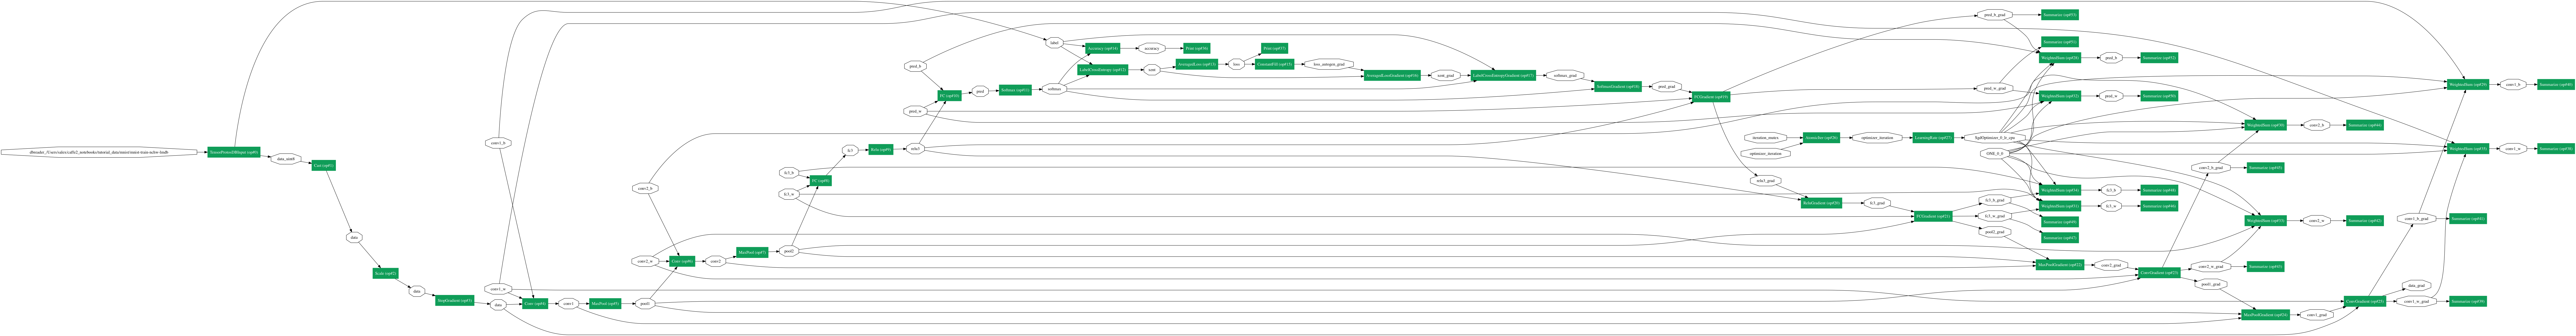

In [11]:
from IPython import display
graph = net_drawer.GetPydotGraph(train_model.net.Proto().op, "mnist", rankdir="LR")
display.Image(graph.create_png(), width=800)

Now, the graph above shows everything that is happening in the training phase: the white nodes are the blobs, and the green rectangular nodes are the operators being run. You may have noticed the massive parallel lines like train tracks: these are dependencies from the blobs generated in the forward pass to their backward operators.

Let's display the graph in a more minimal way by showing only the necessary dependencies and only showing the operators. If you read carefully, you can see that the left half of the graph is the forward pass, the right half of the graph is the backward pass, and on the very right there are a set of parameter update and summarization operators.

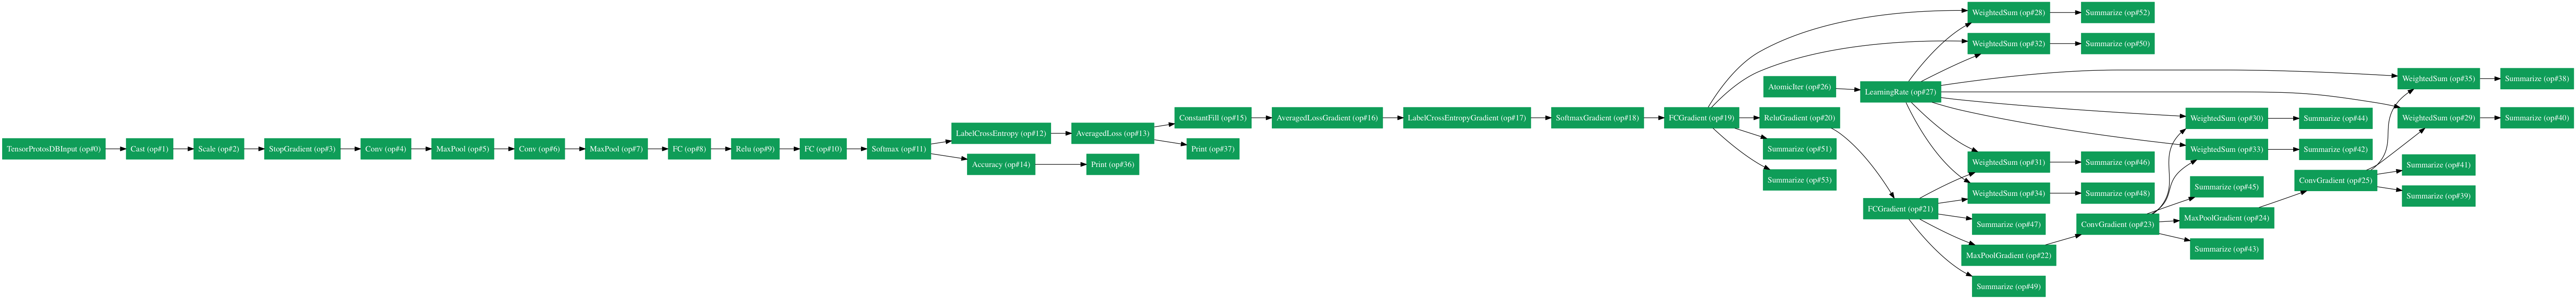

In [12]:
graph = net_drawer.GetPydotGraphMinimal(
    train_model.net.Proto().op, "mnist", rankdir="LR", minimal_dependency=True)
display.Image(graph.create_png(), width=800)

Now, when we run the network, one way is to directly run it from Python. Remember as we are running the network, we can periodically pull blobs from the network - Let's first show how we do this.

Before that, though, let's reiterate the fact that the ModelHelper class has not executed anything yet. All it does is declare the network, which is basically creating the protocol buffers. For example, we will show a portion of the serialized protocol buffer for the training model's main network and the parameter initialization network.

In [13]:
print(str(train_model.net.Proto())[:400] + '\n...')
print(str(train_model.param_init_net.Proto())[:400] + '\n...')

name: "mnist_train"
op {
  input: "dbreader_/Users/salex/caffe2_notebooks/tutorial_data/mnist/mnist-train-nchw-lmdb"
  output: "data_uint8"
  output: "label"
  name: ""
  type: "TensorProtosDBInput"
  arg {
    name: "batch_size"
    i: 64
  }
}
op {
  input: "data_uint8"
  output: "data"
  name: ""
  type: "Cast"
  arg {
    name: "to"
    i: 1
  }
}
op {
  input: "data"
  output: "data"
  name: 
...
name: "mnist_train_init"
op {
  output: "dbreader_/Users/salex/caffe2_notebooks/tutorial_data/mnist/mnist-train-nchw-lmdb"
  name: ""
  type: "CreateDB"
  arg {
    name: "db_type"
    s: "lmdb"
  }
  arg {
    name: "db"
    s: "/Users/salex/caffe2_notebooks/tutorial_data/mnist/mnist-train-nchw-lmdb"
  }
}
op {
  output: "conv1_w"
  name: ""
  type: "XavierFill"
  arg {
    name: "shape"
    ints
...


Next we will run the training procedure. Please note that this process will take a while to run. Keep an eye on the asterisk (In [\*]) or other IPython indicators that the code block is still running.

We perform training by just executing our network many times in a row. Note how during this process we can fetch values of any blobs in the workspace. This allows us to build training plots. 

When using MLP, model accuracy greatly depends on the random initialization of parameters. If your model is staying at about 50% accurate, re-run the notebook, which will start from another random seed and initialize the parameters again.

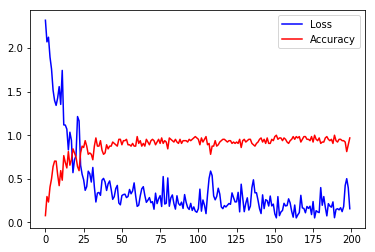

In [14]:
# The parameter initialization network only needs to be run once.
# Now all the parameter blobs are going to be initialized in the workspace.
workspace.RunNetOnce(train_model.param_init_net)

# Creating an actual network as a C++ object in memory.
# We need this as its going to be used a lot.
# So we avoid an object every single time it is used.
 
# overwrite=True allows you to run this cell several times and avoid errors
workspace.CreateNet(train_model.net, overwrite=True)

# Set the iterations number and track the accuracy & loss
total_iters = 200
accuracy = np.zeros(total_iters)
loss = np.zeros(total_iters)

# Now, we will manually run the network for 200 iterations. 
for i in range(total_iters):
    workspace.RunNet(train_model.net)
    accuracy[i] = workspace.blobs['accuracy']
    loss[i] = workspace.blobs['loss']

# After the execution is done, let's plot the values.
pyplot.plot(loss, 'b')
pyplot.plot(accuracy, 'r')
pyplot.legend(('Loss', 'Accuracy'), loc='upper right')

Now we can sample some of the data and predictions. 

Text(0.5,1,u'Prediction for the first image')

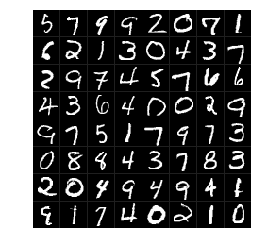

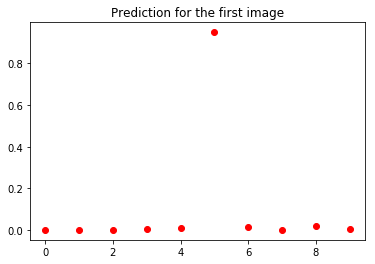

In [15]:
# Let's look at some of the data.
pyplot.figure()
data = workspace.FetchBlob('data')
_ = visualize.NCHW.ShowMultiple(data)
pyplot.figure()
softmax = workspace.FetchBlob('softmax')
_ = pyplot.plot(softmax[0], 'ro')
pyplot.title('Prediction for the first image')

For convolutional models we can also see how they "think", i.e. which features they come up with. Instead of fetching learned weights, which can make less sense to a human, we fetch results of convolving those weights over the input. Note that if this code is rerun after the evaluation phase, the last mini-batch will change, since evaluation and training share the same workspace.

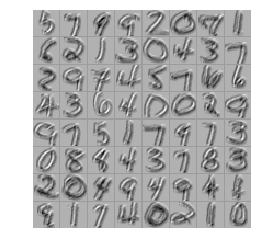

In [16]:
if USE_LENET_MODEL:
    pyplot.figure()
    # We look into the first conv layer output. Change this to conv2 in order to look into the second one. 
    conv = workspace.FetchBlob('conv1')
    
    # We can look into any channel. Think of it as a feature model learned.
    # In this case we look into the 5th channel. Play with other channels to see other features
    conv = conv[:,[5],:,:]

    _ = visualize.NCHW.ShowMultiple(conv)


Remember that we created the test net? We will run the test pass and report the test accuracy here. Note that although test_model will be using the parameters obtained from train_model, test_model.param_init_net must still be run to initialize the input data.
In this run, we only need to track the accuracy and we're also only going to run 100 iterations.

test_accuracy: 0.954200


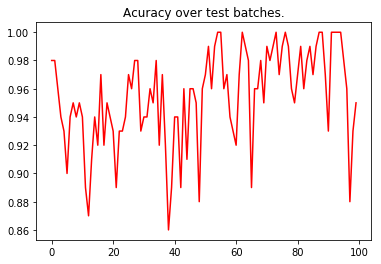

In [17]:
# param_init_net here will only create a data reader
# Other parameters won't be re-created because we selected init_params=False before
workspace.RunNetOnce(test_model.param_init_net)
workspace.CreateNet(test_model.net, overwrite=True)
test_accuracy = np.zeros(100)
for i in range(100):
    workspace.RunNet(test_model.net.Proto().name)
    test_accuracy[i] = workspace.FetchBlob('accuracy')
# After the execution is done, let's plot the values.
pyplot.plot(test_accuracy, 'r')
pyplot.title('Acuracy over test batches.')
print('test_accuracy: %f' % test_accuracy.mean())

Let's save the deploy model with the trained weights and biases to a file. 

In [18]:
# construct the model to be exported
# the inputs/outputs of the model are manually specified.
pe_meta = pe.PredictorExportMeta(
    predict_net=deploy_model.net.Proto(),
    parameters=[str(b) for b in deploy_model.params], 
    inputs=["data"],
    outputs=["softmax"],
)

# save the model to a file. Use minidb as the file format
pe.save_to_db("minidb", os.path.join(root_folder, "mnist_model.minidb"), pe_meta)
print("The deploy model is saved to: " + root_folder + "/mnist_model.minidb")

The deploy model is saved to: /Users/salex/caffe2_notebooks/tutorial_files/tutorial_mnist/mnist_model.minidb


Now we can load the model back and run the prediction to verify it works.

The blobs in the workspace after reset: []
The blobs in the workspace after loading the model: [u'!!META_NET_DEF', u'!!PREDICTOR_DBREADER', u'conv1', u'conv1_b', u'conv1_w', u'conv2', u'conv2_b', u'conv2_w', u'data', u'fc3', u'fc3_b', u'fc3_w', u'pool1', u'pool2', u'pred', u'pred_b', u'pred_w', u'relu3', u'softmax']


Text(0.5,1,u'Prediction for the first image')

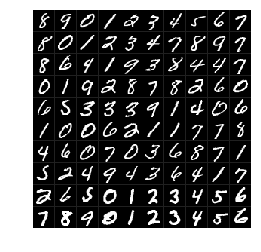

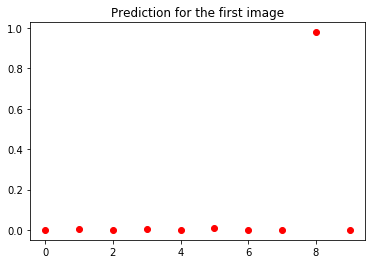

In [19]:
# we retrieve the last input data out and use it in our prediction test before we scratch the workspace
blob = workspace.FetchBlob("data")
pyplot.figure()
_ = visualize.NCHW.ShowMultiple(blob)

# reset the workspace, to make sure the model is actually loaded
workspace.ResetWorkspace(root_folder)

# verify that all blobs are destroyed. 
print("The blobs in the workspace after reset: {}".format(workspace.Blobs()))

# load the predict net
predict_net = pe.prepare_prediction_net(os.path.join(root_folder, "mnist_model.minidb"), "minidb")

# verify that blobs are loaded back
print("The blobs in the workspace after loading the model: {}".format(workspace.Blobs()))

# feed the previously saved data to the loaded model
workspace.FeedBlob("data", blob)

# predict
workspace.RunNetOnce(predict_net)
softmax = workspace.FetchBlob("softmax")

# the first letter should be predicted correctly
pyplot.figure()
_ = pyplot.plot(softmax[0], 'ro')
pyplot.title('Prediction for the first image')

This concludes the MNIST tutorial. We hope this tutorial highlighted some of Caffe2's features and how easy it is to create a simple MLP or CNN model.